# Data Collection

For the first step of the Yelp review analysis, we scraped all reviews of all restaurants in Pittsburgh, PA, United States with the following scraper pipeline. In this pipeline, we scrape name of restaurant, level of price (from 1 to 5), sub-category (basically the country of the restaurant), user name, date of review, star given (from 0 to 5) and the text of review.

In [ ]:
# setup library imports
import io, time, json, random
import requests
from bs4 import BeautifulSoup
import pandas as pd

# import yelp client library
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator

def authenticate(config_filepath):
    """
    Create an authenticated yelp-python client.

    Args:
        config_filepath (string): relative path (from this file) to a file with your Yelp credentials

    Returns:
        client (yelp.client.Client): authenticated instance of a yelp.Client
    """

    conf = open(config_filepath, 'r')
    cred = json.load(conf)
    auth = Oauth1Authenticator(**cred)
    client = Client(auth)
    return client


def parse_page(html, name = None, price = None, categories = None):
    """
    Parse the reviews on a single page of a restaurant.

    Args:
        html (string): String of HTML corresponding to a Yelp restaurant
        name (string): String of name of restaurant
        price (int): price level of the restaurant
        categories (string): String of categories of restaurant, seperated by comma

    Returns:
        tuple(list, string): a tuple of two elements
            first element: String of name of restaurant
            second element: price level of the restaurant
            third element: String of categories of restaurant, seperated by comma
            fourth element: list of dictionaries corresponding to the extracted review information
            fifth element: URL for the next page of reviews (or None if it is the last page)
    """

    soup = BeautifulSoup(html, 'html.parser')
    results = []
    attr_review = {'itemprop':'review'}
    attr_date = {'itemprop':'datePublished'}
    attr_rate = {'itemprop':'ratingValue'}
    attr_text = {'itemprop':'description'}
    attr_user = {'itemprop': 'author'}

    if name == None:
        name = soup.find('h1').text.strip()
        price_category = soup.find('div', class_='price-category')
        price_tag = price_category.find('span', class_='business-attribute price-range')
        if price_tag == None:
            price = -1
        else:
            price = len(price_tag.text)

    for review in soup.findAll('div', attrs = attr_review):
        user = review.find('meta', attrs = attr_user)['content']
        date = review.find('meta', attrs = attr_date)['content']
        rate = float(review.find('meta', attrs = attr_rate)['content'])
        text = review.find('p', attrs = attr_text).text
        results.append([name, price, categories, user, date, rate, text])

    nextpage = soup.find('a', class_='u-decoration-none next pagination-links_anchor')
    if nextpage == None:
        return (name, price, categories, results, None)

    return (name, price, categories, results, nextpage['href'])

def extract_reviews(url, categories):
    """
    Retrieve ALL of the reviews for a single restaurant on Yelp.

    Parameters:
        url (string): Yelp URL corresponding to the restaurant of interest.
        categories (string): The categories of the page.

    Returns:
        reviews (list): list of dictionaries containing extracted review information
    """

    html = requests.get(url).content
    name, price, categories, allreviews, nextpage = parse_page(html, categories = categories)
    while (nextpage != None):
        # wait a random time to avoid being detected scraper
        time.sleep(0.5 + random.random())
        html = requests.get(nextpage).content
        _, _, _, reviews, nextpage = parse_page(html, name, price, categories)
        allreviews.extend(reviews)

    print 'Extracted %d reviews from this business' % len(allreviews)

    return allreviews

def all_restaurants(client, query, category = None):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of yelp.obj.business.Business objects
    """

    results = []
    if category == None:
        param = {'term': 'restaurants'}
    else:
        param = {'term': 'restaurants', 'category_filter': category}

    response = client.search(query, **param)

    total = response.total
    if total > 1000:
        print 'Trying to get over 1000 records (%d), set to 1000' % total
        total = 1000

    i = 0
    for business in response.businesses:
        i += 1
        print i, '/', total, ':\n', business.url
        try:
            results.extend(extract_reviews(business.url, category))
        except Exception:
            print 'Oh maybe we are recognized as a scraper'
            raw_input('Visit Yelp and pass the validation, then press any key to continue')
            try:
                results.extend(extract_reviews(business.url, category))
            except Exception:
                print 'Failed, try again'
                raw_input('press any key to continue')
                continue
            continue

    while i < total:
        param['offset'] = i
        response = client.search(query, **param)
        for business in response.businesses:
            i += 1
            print i, '/', total, ':\n', business.url
            try:
                results.extend(extract_reviews(business.url, category))
            except Exception:
                print 'Oh maybe we are recognized as a scraper'
                raw_input('Visit Yelp and pass the validation, then press any key to continue')
                try:
                    results.extend(extract_reviews(business.url, category))
                except Exception:
                    print 'Failed, try again'
                    raw_input('press any key to continue')
                    continue
                continue
    return results

if __name__ == '__main__':
    reviews = []
    random.seed(15688)
    client = authenticate('yelp.json')
    with open('category.list', 'r') as category_file:
        for line in category_file:
            print line
            if not line.startswith('#'):
                reviews.extend(all_restaurants(client, 'Pittsburgh, PA', line.strip()))
    pd.DataFrame(reviews).to_pickle('dataset.pickle')


Note: This piece of code with take several hours to run (12 hours on my Macbook Air!), and it could be interrupted by the Yelp scraper detection serveral times where we will need to manually pass the validation in this case. So we don't recommend you to run this piece of code in the notebook, the python script file can be found [here](https://github.com/lidajian/YelpAnalysis/blob/master/scraper.py).

The scraped data in can be found in our [github](https://github.com/lidajian/YelpAnalysis/blob/master/data/pittsburgh_restaurants.pickle), the data file is in Python pickle format and can be easily imported as `pandas.DataFrame` object.

In [1]:
import pandas as pd
df = pd.read_pickle("./data/pittsburgh_restaurants.pickle")
df.columns = ['restaurant', 'price_range', 'category', 'user', 'date', 'rating', 'review']

First let's have a glimpse to the data we have

In [2]:
print df.dtypes
print df.head()

restaurant      object
price_range      int64
category        object
user            object
date            object
rating         float64
review          object
dtype: object
    restaurant  price_range category        user        date  rating  \
0  Grandma B’s            1    halal     Mark R.  2016-11-03     5.0   
1  Grandma B’s            1    halal      Dan T.  2016-09-18     4.0   
2  Grandma B’s            1    halal  Maurice J.  2016-06-13     5.0   
3  Grandma B’s            1    halal    Karol R.  2016-07-13     5.0   
4  Grandma B’s            1    halal        T R.  2016-08-28     5.0   

                                              review  
0  Halal hot wings very tasty, well seasoned, fis...  
1  Mom and pop stop - cheap, good and affordable,...  
2  I've frequented this place on several occasion...  
3  Breakfast is cooked to order. The food is deli...  
4  This place is RIDICULOUSLY GOOD. I got eggs, p...  


Before we can do high level analysis to the scraped data, let's first take a simple analysis to the data we scraped.

# Simple Analysis to Data

As a first step of data analysis, we use some tools to simply visualize our data, so as to have a first impression to the data we have.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

A statistical summary of price range and rating is shown:

In [4]:
print df.describe()

       price_range        rating
count  76989.00000  76989.000000
mean       1.90144      3.721038
std        0.56156      1.273594
min       -1.00000      1.000000
25%        2.00000      3.000000
50%        2.00000      4.000000
75%        2.00000      5.000000
max        4.00000      5.000000


Note: The reason the minimum price range is -1 is that when we scraped the price we found some of the restaurant don't have price range label. We ignore all reviews that have no price data when analysing relations of price.

In [5]:
df_price = df[df['price_range'] >= 0]

## Restaurants at different price range
An histgram of restaurants at different price range is shown below:

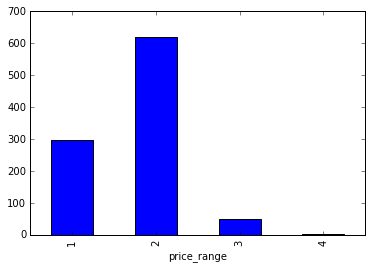

In [6]:
df_price.groupby(by = 'price_range')['restaurant'].apply(lambda x: len(pd.Series.unique(x))).plot(kind = 'bar')

As we can see in the histgram, the distribution tends to be bell shaped distribution, with most restaurants at price range 2 (\$11 - 30). This indicates that restaurants at price range 2 are the common choice when people choose to open restaurants.

# Length of review

It seems that the length of reviews are quite long (unlike reviews in some of the other sites), let's find out the distribution of the length of reviews.

Average length of review: 121.130655


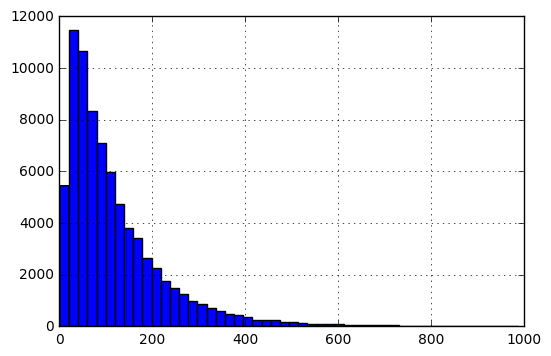

In [9]:
df_review_wordlen = df['review'].apply(lambda x: len(x.split()))
df_review_wordlen.hist(bins = 50)
print 'Average length of review: %f' % df_review_wordlen.mean()

The average length of review is about 121 words (coarce estimation), and the distribution is a $\chi^2$-like distribution.

## Reviews with different ratings

We can also have a look at the distribution of ratings.

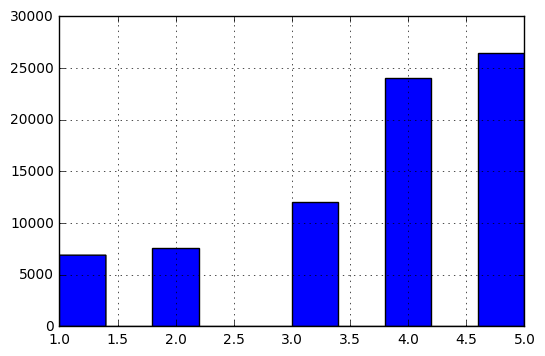

In [32]:
df['rating'].hist()

Normally we expect the distribution of rating to be a bell shaped distribution. But as we can see in the histgram, the evaluation of customers seems to be quite good, so more reviews are at higher ratings.

Why is that? We can have a guess:
* Customers who think highly of the experience in the restaurants are more likely to write reviews (that should be about 121 on average)
* Customers who have complaint about the restaurants may not be so interested in write complaints in Yelp
* The average quality of restaurants are good

## Correlation between price range and rating

Does higher price indicate higher food and service quality? Let's make a histgram to figure out:

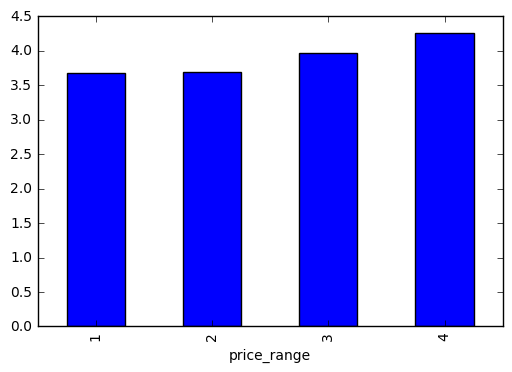

In [50]:
df_price.groupby(by = 'price_range')['rating'].mean().plot(kind = 'bar')

There are a certain correlation between price and ratings. The higher price a restaurant is, the higher ratings it has. However the difference between price range 1 and price range 2 is quite small, indicating that the food and service quality of the two are similar.

In fact, the restaurants of price range 1 and 2 are fast foods or regular dinners, so people may not be concerned about the food or service quality as much as restaurants of the rest two price range. With this intuition, customers will be more strict to higher price range restaurants and the actual food/service quality difference between higher price restaurants and lower price restaurants could be larger than we see.

## Correlation between price and average number of reviews

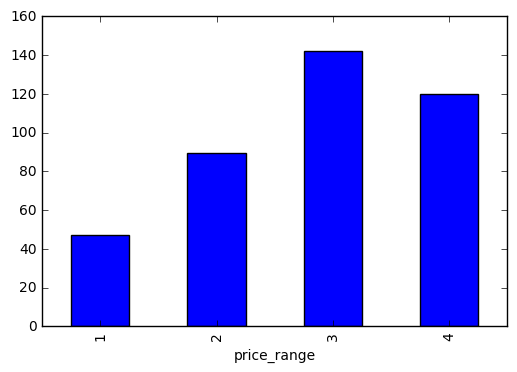

In [56]:
df_price.groupby(by = 'price_range').apply(lambda x: float(x.shape[0])/len(x['restaurant'].unique())).plot(kind = 'bar')

Restaurants of price range 3 has the largest average number of reviews. Indicating that customers are more prone to write reviews after their meal in a restaurants of price range 3.

This can also be reasoned, since price range 1 and 2 are regular meals, people may not be so interested in writing reviews; while price 3 and 4 are meals of more formal occasions lile meetings and parties, so people may be more passionate in writing reviews. As we know, the higher the price is, the less customer, there could be. This may be why there are less review for price range 4 than price range 3.

# Categorized Analysis

In this part, we focus on analysing properties of restaurants of different category and try to find out characterisics of restaurants of different categories.

## Average ratings of different sub-categories

When we scrape the data, we manually choose to scrape sub-categories with regional meanings. So `category` column shows the region of flavor the restaurant belongs to. Let's first have a look at the rating ranking of different sub-categories.

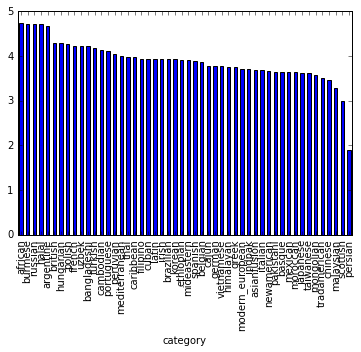

In [7]:
df.groupby(by = 'category')['rating'].mean().sort_values(ascending = False, inplace = False).plot(kind = 'bar')

## Using category lists

We actually have a [list](https://github.com/lidajian/YelpAnalysis/blob/master/category.list) that categorize sub-categories into different bigger regions. 
 
* middle east asia
* east asia
* south asia
* europe
* north american
* south american
* africa

To use the category list, we first import it from file.

In [12]:
def load_category (file_name):
    categories_name = []
    categories = {}
    temp = open(file_name,'r').read().split('\n')
    
    for term in temp:
        if term.startswith("#"):
            categories[term[2:]]=set()
            categories_name.append(term[2:])
            
        else:
            categories[categories_name[len(categories_name)-1]].add(term)
   
    return categories_name, categories

This is a glimpse of all categories:

In [13]:
categories_name, categories = load_category("category.list")
i=1
for name in categories_name:
    print i,'Category: ', name, '\tnumber of sub-categories:',len(categories[name])
    print categories[name]
    i+=1
    print

1 Category:  middle east asia 	number of sub-categories: 9
set(['indpak', 'arabian', 'mideastern', 'halal', 'himalayan', 'afghani', 'pakistani', 'syrian', 'persian'])

2 Category:  east asia 	number of sub-categories: 9
set(['hkcafe', 'chinese', 'panasian', 'taiwanese', 'japanese', 'asianfusion', 'mongolian', 'korean', 'thai'])

3 Category:  south asia 	number of sub-categories: 8
set(['singaporean', 'filipino', 'vietnamese', 'malaysian', 'bangladeshi', 'burmese', 'laotian', 'cambodian'])

4 Category:  europe 	number of sub-categories: 28
set(['portuguese', 'irish', 'czech', 'basque', 'mediterranean', 'moroccan', 'spanish', 'scottish', 'srilankan', 'polish', 'modern_european', 'turkish', 'german', 'belgian', 'austrian', 'hungarian', 'ukrainian', 'french', 'iberian', 'catalan', 'slovakian', 'armenian', 'russian', 'uzbek', 'british', 'scandinavian', 'greek', 'italian'])

5 Category:  north american 	number of sub-categories: 8
set(['cajun', 'tradamerican', 'mexican', 'nicaraguan', 'hawai

In [14]:
category_dict = {}
for name in categories_name:
    for category in categories[name]:
        category_dict[category] = name
df_categorized = df.copy()
df_categorized['category'] = df_categorized['category'].apply(lambda x: category_dict[x])

Then, let us explore the overal statistic of each category:

We load the data into a dictionay `processed_category`

In [15]:
processed_category = {}
for name in categories_name:
    processed_category[name] = df_categorized[df_categorized['category'] == name].copy()
    processed_category[name].reindex()

In [104]:
print '%20s|\t%10s|\t%10s|\t%10s|\t%10s|\t%10s' % ('category','number','rating(mean)','rating(variance)','price(mean)','price(variance)')
print '------------------------------------------------------------------------------------------------------------------'
for name in processed_category.keys():
    print '%20s|\t%10d|\t%10.4f|\t%10.4f|\t%10.4f|\t%10.4f' % (name, len(processed_category[name]), 
                                    processed_category[name]['rating'].mean(),  processed_category[name]['rating'].var(),
                                    processed_category[name]['price_range'].mean(),  processed_category[name]['price_range'].var()        )


            category|	    number|	rating(mean)|	rating(variance)|	price(mean)|	price(variance)
------------------------------------------------------------------------------------------------------------------
              europe|	     18370|	    3.8431|	    1.5909|	    1.9820|	    0.3664
           east asia|	     15963|	    3.6981|	    1.6363|	    1.8530|	    0.2736
    middle east asia|	      2802|	    3.8269|	    1.6091|	    1.8837|	    0.1307
              africa|	       111|	    4.0541|	    0.9607|	    1.8108|	    0.2093
      north american|	     35632|	    3.6169|	    1.6458|	    1.8898|	    0.3233
          south asia|	      1528|	    3.8364|	    1.4192|	    1.5988|	    0.2443
      south american|	      2583|	    4.2350|	    1.0458|	    1.9911|	    0.2226


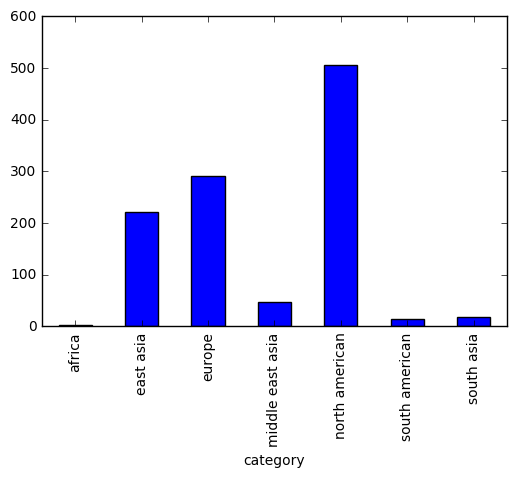

In [59]:
df_categorized.groupby(by = 'category')['restaurant'].apply(lambda x: len(x.unique())).plot(kind = 'bar')

[-1, 7, 0, 6]

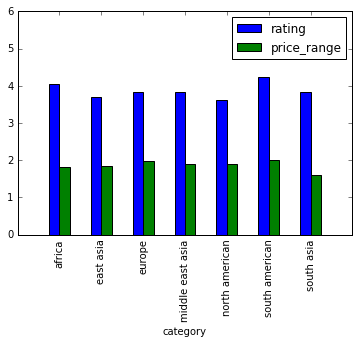

In [105]:
df_categorized.groupby(by = 'category')['rating', 'price_range'].mean().plot(kind = 'bar').axis([-1, 7, 0, 6])

As we can see from the figure, south american food comes the first in both rating and price, indicating that south american restaurants are more likely to be high level restaurants. It is also noticable that South Asian restaurants are of the lowest average price, while maintains an acceptable rating. Restaurants with similar ratings as South Asian restaurants - European and Middle East Asian restaurants, are much more expensive. As a chinese, we are surprised to find that the East Asian restaurants have a really low ratings, though our price is also relatively low.

South American restaurants have the lowest ratings, however the most number of reviews, making us start to consider the influence of number of reviews to average ratings. As a comparison, we can see that African food have a second highest rating, however the least number of reviews, so the samples of African restaurants may not be representative enough for analysis.

To conclude, for people who would like to open a new restaurant, South American and South Asian restaurants may be a good choice. For people who is willing to take risk, opening a African restaurants may get you both high reputation and high profit.

# What's in the reviews?

We have finish analysing for people who wants to open a new restaurants, now let do something for restaurant owners. Owners can look at all reviews to find out what it tells. However this task may be too elaborative, especially for owners who wants to understand the categories and improve themself according to merits of the other categories. In this part we are trying to analyse the content of reviews to find out what reviews tells us about the restaurants in a specific category.

## Cleanning the words

In [106]:
import nltk
from collections import Counter

import string
import numpy as np
import sklearn
import scipy.sparse as sp
import math

We define a function to tokenize the text reviews, which will remove the punctuations and words with digits.

In [107]:
from nltk.stem import WordNetLemmatizer
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    text = text.lower()
    text = text.replace("'s","")
    text = text.replace("'","")
    replace_punctuation = string.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(replace_punctuation)
    
    tokens = nltk.word_tokenize(text)
    ans = []
    for token in tokens:
        if has_digit(token):
            continue
        try:
            lemma = lemmatizer.lemmatize(token)
            ans.append(lemma)
        except:
            pass
    return ans

def has_digit(s):
    return any(i.isdigit() for i in s)

In [108]:
for name in categories_name:
    processed_category[name]['review'] = processed_category[name]['review'].apply(lambda x: process(x.encode('utf-8')))

Although the ntlk has a stopword list, but in practice, the "rare words" are related to the input dataset. Therefore, we need to calculate the rare words, then remove the stopwords.

In [270]:
def get_rare_words(one_category):
    count = Counter()
    for text in one_category['review']:
        for word in text:
            count[word] += 1
    
    rare = []
    n = len(count)
    for word in count:
        if count[word] == 2:
            rare.append(word)
    sort = sorted(rare)
    return sort

rare_words = []
for name in categories_name:
    rare_words += (get_rare_words(processed_category[name]))
    
print len(rare_words)

15023


## Find out common 'attributes'  with TFIDF

Except the rare words, we also need to find out the 'identity words' which has higher tfidf value than the 'common words'. In the following part, we simply used the TfidfVectorizer of sklearn to implement this.

In [271]:
from sklearn.feature_extraction.text import TfidfVectorizer

def create_features(processed_category, rare_words):
    """ creates the feature matrix using the processed tweet text
    Inputs:
        tweets: pd.DataFrame: tweets read from train/test csv file, containing the column 'text'
        rare_words: list(str): one of the outputs of get_feature_and_rare_words() function
    Outputs:
        sklearn.feature_extraction.text.TfidfVectorizer: the TfidfVectorizer object used
                                                we need this to tranform test tweets in the same way as train tweets
        scipy.sparse.csr.csr_matrix: sparse bag-of-words TF-IDF feature matrix
    """
    data = []
    count = 0
    stopwords = set(nltk.corpus.stopwords.words('english') + rare_words)
    for name in categories_name:
        reviews =  processed_category[name]['review']
        sentence = []
        for review in reviews:
            s = ' '.join(word for word in review)
            sentence.append(s)
        
        ss = ' '.join(sentence)
        data.append(ss)
    
    vectorizer = TfidfVectorizer(min_df=1, stop_words=stopwords)
    X = vectorizer.fit_transform(data)
    return (vectorizer, X)    


In [272]:
(tfidf, X) = create_features(processed_category, rare_words)

Now, let us find out the top N words with highest tfidf and the lowest tfidf:

In [282]:
features = tfidf.get_feature_names()
indices_highest = np.argsort(tfidf.idf_)[::-1]
indices_lowest = np.argsort(tfidf.idf_)[::1]

top_n = 100
top_features_highest = [features[i] for i in indices_highest[:top_n]]
print '-------------- Top', top_n, ' words with Highest tfidf --------------'
print top_features_highest


-------------- Top 100  words with Highest tfidf --------------
[u'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', u'icka', u'icarus', u'icb', u'icee', u'icewine', u'icey', u'ichaban', u'ichorous', u'icicle', u'icious', u'ickiness', u'ibuprofen', u'iconry', u'idealic', u'idealistic', u'ideological', u'ides', u'idiazabal', u'idiazabel', u'idiocracy', u'idli', u'ibus', u'ibu', u'hygience', u'hypotension', u'hymnal', u'hypercritical', u'hypermodern', u'hyphen', u'hyphenatedly', u'hyping', u'hypnotized', u'hypocrite', u'hypoglycemia', u'hypothesize', u'ibrico', u'hypothetical', u'hysteria', u'hysterically', u'hziwvfolvlk', u'iand', u'ibanez', u'ibe', u'iberian', u'iberico', u'idris', u'idustry', u'idyllic', u'illl', u'ika', u'ikan', u'ike', u'iknow', u'iks', u'ikv', u'ilas', u'illegals', u'illicitly', u'illogically', u'ier', u'illuminate', u'illusionist', u'illustrating', u'illustration', u'ilpizzaiolo', u

It's quite suprising at first quite a lot of the top 100 words with highest tfidf are some strange that don't come up with our common sense. However, if we pick the 200~500 words to see, we find that high tfidf is not that important for our dataset.

In [281]:
top_features_highest = [features[i] for i in indices_highest[:300]][200:300]
print top_features_highest

[u'indispensable', u'indisputably', u'indeterminate', u'indistinct', u'individualized', u'indiviudal', u'indivudual', u'indonesia', u'indopak', u'indsutrial', u'inducive', u'inductive', u'indianized', u'indestructible', u'imbiss', u'incremental', u'incomprehensible', u'incomprehension', u'incongruent', u'inconstant', u'inconstantly', u'incorporation', u'incorrigible', u'increadible', u'incredibility', u'incubated', u'inder', u'incubator', u'incumbent', u'incurred', u'incus', u'ind', u'indefensible', u'indeible', u'indentation', u'independence', u'indulges', u'industrialist', u'industrially', u'infornt', u'inflamed', u'inflatable', u'inflect', u'inflict', u'influencing', u'informally', u'informatively', u'informer', u'informercial', u'infrared', u'industrious', u'infringing', u'infuriate', u'infusd', u'inga', u'ingedients', u'ingira', u'inglese', u'ingoodhands', u'ingot', u'infirmity', u'infinitus', u'infinitesimal', u'inferring', u'industrt', u'industrypgh', u'inebriant', u'inedable', 

So let us take a look at the words with low tfidf:

In [283]:
top_n = 100
top_features_lowest = [features[i] for i in indices_lowest[:top_n]]
print 
print '-------------- Top', top_n, ' words with Lowest tfidf --------------'
print top_features_lowest


-------------- Top 100  words with Lowest tfidf --------------
[u'dark', u'bad', u'happy', u'finally', u'wednesday', u'week', u'delicious', u'weekday', u'deliciously', u'deliciousness', u'oily', u'wedge', u'hard', u'delightful', u'ok', u'possible', u'post', u'delivered', u'delivery', u'back', u'filling', u'filled', u'recently', u'delight', u'happily', u'delectable', u'wed', u'important', u'portion', u'portioned', u'way', u'talked', u'soaked', u'hanging', u'taking', u'takeout', u'finished', u'take', u'definitely', u'magical', u'screen', u'finger', u'roasted', u'degree', u'weather', u'fine', u'jewel', u'happened', u'scratch', u'find', u'welcomed', u'might', u'pea', u'well', u'desire', u'despite', u'average', u'main', u'available', u'mainly', u'receive', u'whenever', u'havent', u'authentic', u'reservation', u'resembled', u'whim', u'diamond', u'leaving', u'impressive', u'somehow', u'make', u'one', u'didnt', u'leave', u'attentive', u'sweet', u'mexican', u'soggy', u'away', u'legit', u'table

Low tfidf means not good enough to represent the 'difference' between categories, however on the other hand, showing the common attributes among them. We can see that among these words with low tfidf, most of them are sentiment words such as 'bad', 'happy', some are adjectives to objects such as 'delicious', 'ok', and some are noun of such as 'wednesday', 'potato'.

Therefore, we should seperate these type of words into 3 types: 
* Sentimental words
* Adjectives to describe restaurants (food, environment, etc)
* Nouns represente attributes (potato, wednesday, ect)

### Sentimental words

We import sentimantal word list from the AFINN-111.txt, which is a list of words rated from -5(negative) to +5(positive). We use these words as a filter to seperate reviews into positive, negative, and netural. 

In [292]:
sentimental_dict = {}
for line in open("./data/AFINN-111.txt"):
    word, score = line.split("\t")
    sentimental_dict[word] = score
print len(sentimental_dict)


2477


### Word cloud
In the following section, we will use Word Cloud to visualize the most common words of each category. WordCloud is a convenient opensourse tool, which can download from http://amueller.github.io/word_cloud/

In [296]:
from collections import Counter
from string import punctuation

def word_counter(all_review, stop_words, n=100):
    without_stp  = Counter()
    for review in all_review:
        without_stp.update(w for w in review if w not in stop_words)
    return [y for y in without_stp.most_common(n)]

### Remove words with low tfidf, and only focus on non-sentimental words

We also include a personalized stop word list in ./data/my_stopword_list.txt

In [ ]:
personalize_stop_word = []
for line in open("./data/my_stopword_list.txt"):
    word = line.rstrip('\n')
    if len(word)==0:
        continue
    else:
        personalize_stop_word.append(word)
print len(personalize_stop_word)


In order to remove the words with high tfidf, we need to include these words into the stopwords list

In [331]:
top_n = 200
top_features_lowest = [features[i] for i in indices_lowest[:top_n]]

In [332]:
stopwords_with_sentimental = set(nltk.corpus.stopwords.words('english') + 
                                 rare_words + sentimental_dict.keys() + personalize_stop_word 
                                + top_features_lowest)

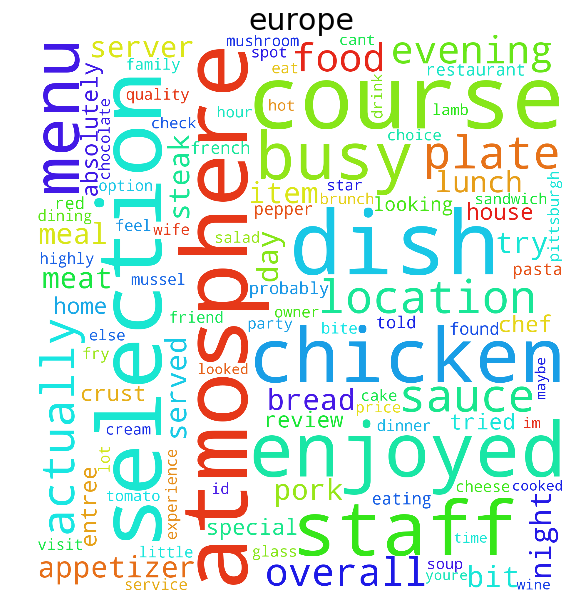

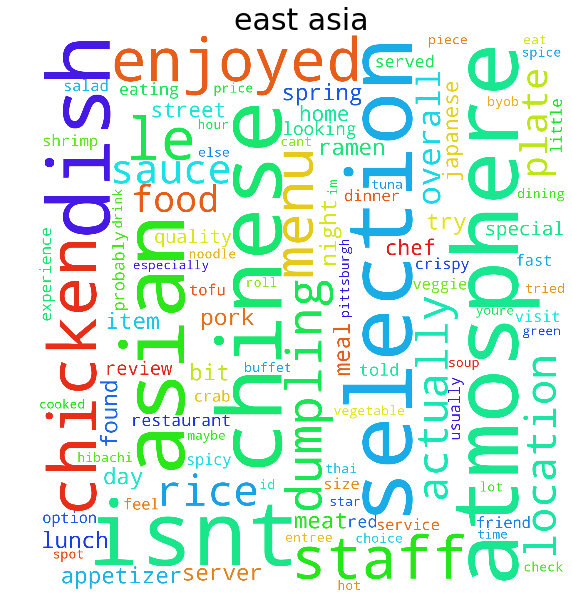

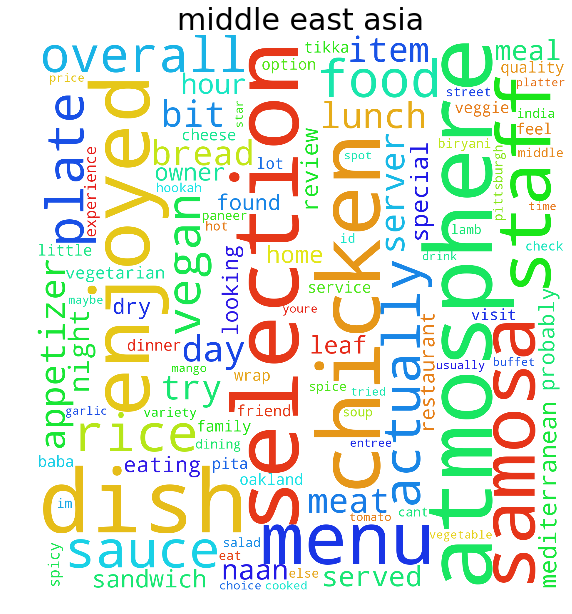

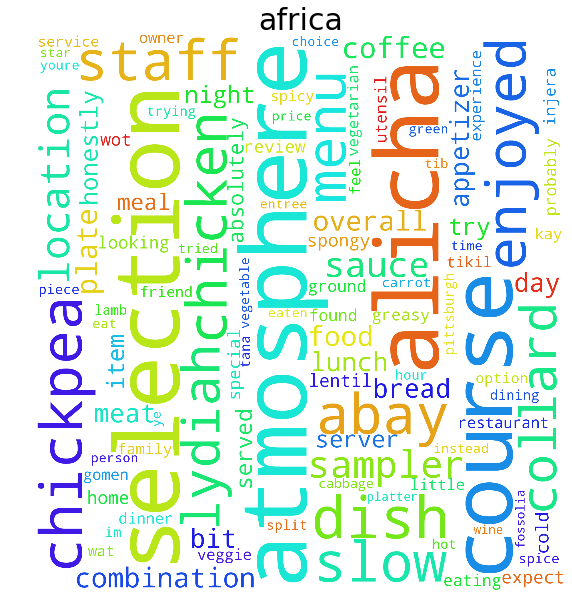

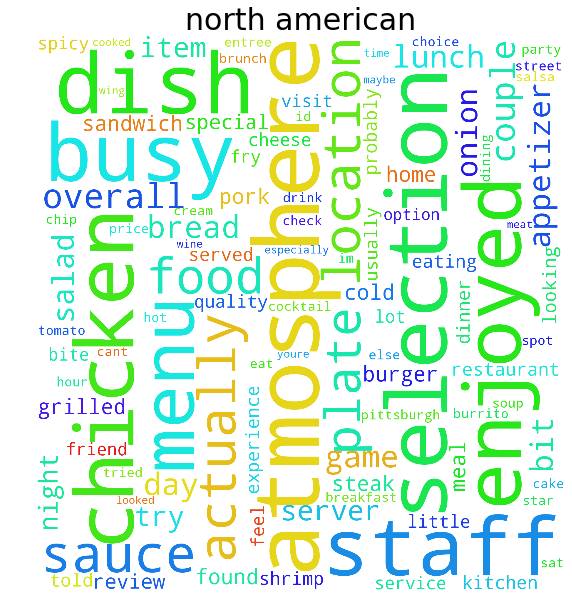

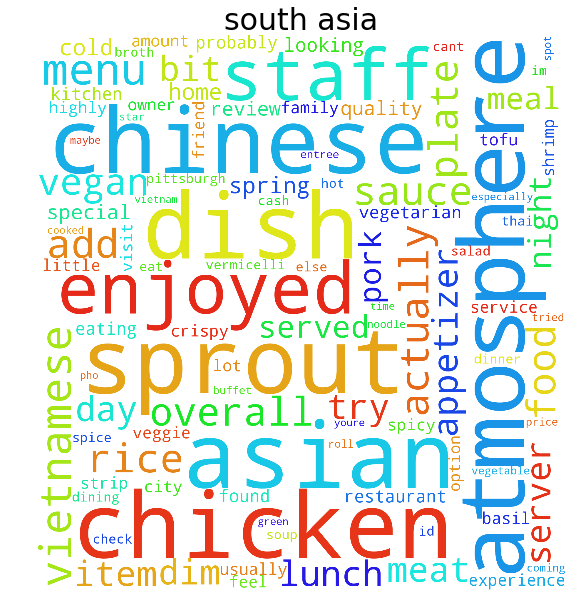

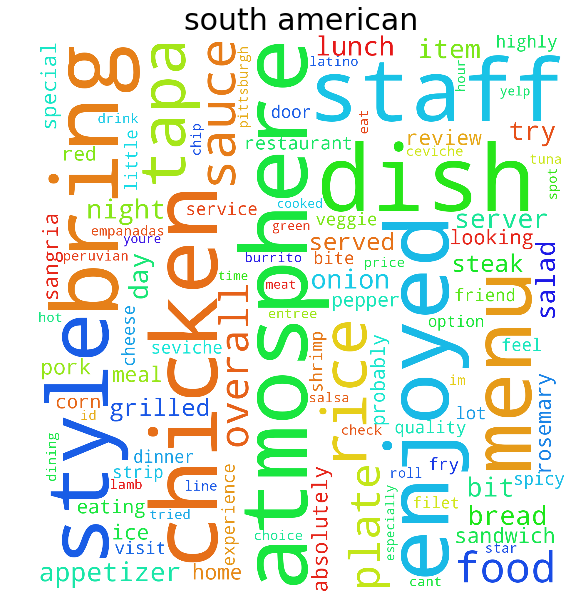

In [333]:
%matplotlib inline 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import scipy
from scipy import ndimage


# num_most_common_word : the number of the most common words we want to extract

def plot_wordCloud(processed_category, rare_words, num_most_common_word):
    i=0
    for name in processed_category.iterkeys():
        without_stp = word_counter(processed_category[name]['review'], rare_words, num_most_common_word)
        str = ""
        w =  [pair[0] for pair in without_stp]
        str = " ".join(w)
        wordcloud = WordCloud(background_color='white',width=1800,height=1900).generate(str)
        plt.figure(i+1, figsize=(10,10), dpi=100)
        plt.axis('off')
        plt.title (name, size=30)
        plt.imshow(wordcloud, cmap=plt.cm.gray)
        i+=1
        
        
plot_wordCloud(processed_category, stopwords_with_sentimental, 100)

As we can see, word cloud intuitively provides a first insight of the keywords of a specific type of restaurants, for example, South America related to some "delicious", "ordered", "good". However, when we just extracted 50 words for each type of restaurant, most of the words are sentimental words or evaluation words, such as "good", "amazing", "delicious", "flavor", and there's an obvious overlapping among different categores.
...................... Wait to finish

What we want is to find out what makes that type of restaurant different, what are the factors that lead to the success or failure of that type of restaurant.

## LDA model

gensim is a powerful tool to generate topic models, and we generate 20 topis for each type of restaurants.

in order to use gensim, we need to fisrt install gensim using: 

pip install gensim

In [29]:
import gensim
from gensim import corpora, models,matutils

lda_corpus_each_region = {}
lda_model_each_region = {}
for name in processed_category.keys():
    print 'analying LDA model of ' + name
    data_list = processed_category[name]['review']
    dic =corpora.Dictionary(data_list)
    corpus = [dic.doc2bow(text) for text in data_list]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    lda = models.LdaModel(corpus_tfidf, id2word = dic, num_topics = 20)
    corpus_lda = lda[corpus_tfidf]
    lda_corpus_each_region[name] = corpus_lda
    lda_model_each_region[name] = lda


analying LDA model of europe


TypeError: doc2bow expects an array of unicode tokens on input, not a single string

Our LDA model is now stored as ldamodel. We can review our topics with the print_topic and print_topics methods, let us analyse the topics of europe, These are the top 5 words associated with 5 random topics. The decimal number is the weight of the word it is multiplying, i.e., how much does this word influence the particular topic.

In [42]:
europe_topics = (lda_model_each_region['europe']).show_topics(num_topics=5, num_words=10)
for topic in europe_topics:
    print topic
    print

(115, u'0.043*"tomorrow" + 0.041*"frequently" + 0.033*"driving" + 0.024*"plastic" + 0.023*"wonderfully" + 0.021*"pro" + 0.021*"stepping" + 0.021*"dropping" + 0.020*"exact" + 0.019*"con"')

(92, u'0.015*"grill" + 0.014*"owner" + 0.012*"sofra" + 0.010*"platter" + 0.007*"yogurt" + 0.006*"clean" + 0.006*"lamb" + 0.006*"salumi" + 0.005*"amazing" + 0.005*"fresh"')

(147, u'0.022*"med" + 0.020*"alihan" + 0.018*"license" + 0.017*"selling" + 0.016*"grub" + 0.014*"te" + 0.013*"mad" + 0.012*"fettuccine" + 0.012*"pastitsio" + 0.012*"freshness"')

(199, u'0.072*"owned" + 0.054*"shish" + 0.047*"tea" + 0.034*"nicest" + 0.023*"everybody" + 0.023*"burrito" + 0.020*"frequent" + 0.019*"operated" + 0.018*"diet" + 0.015*"family"')

(168, u'0.035*"coworkers" + 0.033*"welcome" + 0.030*"wide" + 0.025*"downside" + 0.023*"kid" + 0.020*"sleek" + 0.017*"allergy" + 0.017*"drive" + 0.015*"alike" + 0.013*"daily"')



** The number of topics needs to be adjust, and we choose to pick 20 topics for each type of restaurants. **

而主题模型是迅速汇总信息的最快方式。用户可以快速探索不同的主题气泡，并基于点评中词条的出现频率找出问题。例如，如果时间是一个很重要的问题，那么用户在开餐厅时就可以利用这一点。

we also want to vesualize the LDA model, so we use the python package pyldavis

pip install pyldavis.  不知道需不需要Visualization LDA model. 看后面我们的篇幅怎么样，下面有两个API可以调用。我觉得第一个比较酷炫，但是第二个比较manual

http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=1&term=
